# Chapter 5b - Continuous operation

Now we understand the basics of stoicheometry and solving a set of linear equations in a miatrix formulation. We have also been introduced to the cmol balance for solving rate expressions via numerical integration. We now want to move onto continuous reactors where substrate is constantly entering the reactor and where products are leaving the reactor. 

<img src="inout.png" width="550" />

Let's continue with our example of glucose forming acetic and propionic acid:

<img src="bac1.png" width="600" />

We have shown that the following equation desrscribes the overall equation and that the stoicheometry can vary depending on the growth ($\mu$) and maintenance ($\theta$) characteristics of the organims facilitating the reaction.

$$ CH_2O+ NH_3 → X+CH_2O+CH_2O_{2/3}+CO_2+H_2O $$

In the previous example we had a batch system where all substrate was loaded upfront and where no streams enetered of left the system. In this example we will be continuously feeding to the system while also continuously removing from the system. Note that the inlet flowrate will be the same as the outlet flowrate at all times.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
mumax,thetamax = 0.12,0.3
Ks=0.003

Remember the stoicheometrix matrix from the previous notebook. Ensure that you remember what this matrix look like. Without this no calculation will be possible:

<img src="mat3.png" width="550" />

In [3]:
import pandas
S = np.matrix(pandas.read_excel('matrix1.xlsx'))

In this example we will seperate between the rates obtained from **reponse_fun** and the cmol balance of the fermenter equation **(ferm_eq)**. Note that the multiplication with $C_X$ is not part of the **response_fun**. 

In [4]:
def response_fun(C):
    
    Cs, Cx, Ca, Cp = C[0],C[1],C[2],C[3]   #Considered components
    
    mu=mumax*(Cs/(Ks+Cs))        #this terms reduces mu or theta as substrate becomes limited, more about this later
    theta=thetamax*(Cs/(Ks+Cs))

    C= np.matrix([0, 0, 0,0,mu,0,theta]).T
    r = np.linalg.solve(S, C) 
    
        
    return [r[0,0],   # glucose-substrate S
            r[2,0],   # biomass X
            r[3,0],   # acetic
            r[4,0]]   # propionic  

Let's have a look at the cmol balance for this reactor or fermenter:

\begin{align*}
\frac{dC_i}{dt} &= D(C^F_i - C_i) + r_i C_X \\
\end{align*}

Remember that **$D=\frac{Q}{V}$** is the dilution rate and that it is the inverse of the hydraulic retention time (**HRT**)

$$D=\frac{1}{HRT}$$

If the flowrate through the fermenter is small the average molecule will spend a long time (HRT) in the fermenter, while if the flowrate is big the average molecule will spend a short time in the fermenter. 

In [5]:
D=1/10 #average molecule spend ten day in reactor - units 1/day

We need to now the concentration of the incoming feed **($C_F$)**

In [6]:
Cf=[0.1,0,0,0]  #S,X,A,P only glucose being fed

In [7]:
def ferm_eq(t,C):
    
    Cs, Cx, Ca, Cp = C[0],C[1],C[2],C[3]  # order of components very important 
    
    r=response_fun([Cs, Cx, Ca,Cp])      # this is the 'fetching' from the response function
    
    dcsdt=D*(Cf[0]-C[0]) +  r[0]*Cx
    dcxdt=D*(Cf[1]-C[1]) +  r[1]*Cx
    dcadt=D*(Cf[2]-C[2]) +  r[2]*Cx
    dcpdt=D*(Cf[3]-C[3]) +  r[3]*Cx
    
    return [dcsdt,
            dcxdt,    
            dcadt,
            dcpdt] 

Let's define the initial concentration conditions within the reactor at **t=0**. Don't confuse this with the feed concentrations **Cf**

In [8]:
Co=[0,0.01,0,0] #only cells in the reactor initially

So we have a vessel with cells **($C_X$)** and a feedstream **($Q$)** with substrate **($C_S$)**. Let's do the standard solve_ivp thing to see what happens over time in the fermenter:

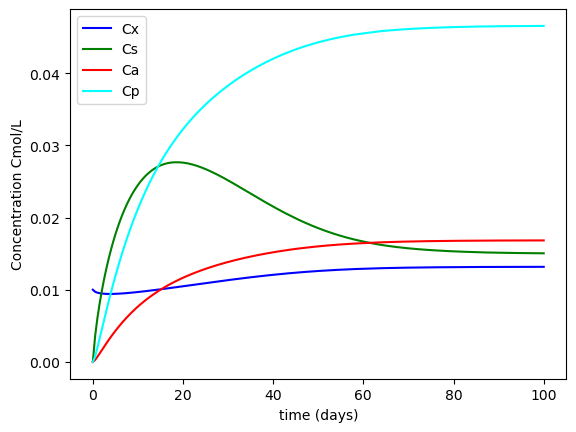

In [9]:
tmax = 100                               # time to integrate to  
tspan=np.linspace(0,tmax,200)            # define the timespan of the integration and increments where values will be reported
tper = (0,tmax)                          #defining the starting and end time for the solve_IVP function

Ci = solve_ivp(ferm_eq, tper, Co, dense_output = True, method = "LSODA")    # integration via odeint that calls apon response_fun

Cs, Cx, Ca, Cp = Ci.sol(tspan)

plt.figure(3)
plt.plot(tspan, Cx, color='blue', label='Cx')
plt.plot(tspan, Cs, color='green', label='Cs')
plt.plot(tspan, Ca, color='red', label='Ca')
plt.plot(tspan, Cp, color='cyan', label='Cp')
plt.legend(loc='best')
plt.ylabel('Concentration Cmol/L') 
plt.xlabel('time (days)') 
plt.show() 

From the graph above you can see that steady state is achieved after about 80 days. The figure above gives the dynamic simulation of the process. It is also possible to just solve for the steady state by using the equations from **ferm_eq** and finding the concentrations where the slopes $\frac{dC_i}{dt}=0$ are zero. In order to do this we use the **ferm_eq** without including a time value in the function. The function of **ferm_eq_ss** are identical to **ferm_eq** except for the function handle not including a **t**.

In [10]:
def ferm_eq_ss(C):
    
    Cs, Cx, Ca, Cp = C[0],C[1],C[2],C[3]  # order of components very important 
    
    r=response_fun([Cs, Cx, Ca,Cp])      # this is the 'fetching' from the response function
    
    dcsdt=D*(Cf[0]-C[0]) +  r[0]*Cx
    dcxdt=D*(Cf[1]-C[1]) +  r[1]*Cx
    dcadt=D*(Cf[2]-C[2]) +  r[2]*Cx
    dcpdt=D*(Cf[3]-C[3]) +  r[3]*Cx
    
    return [dcsdt,
            dcxdt,    
            dcadt,
            dcpdt] 

We can use the nonlinear solver **fsolve** to find the steady state, by giving it an initial estimation. 

In [11]:
from scipy.optimize import fsolve
guess=[0.01,0.01,0.01,0.05]
steadystate=fsolve(ferm_eq_ss,guess)
steadystate

array([0.015     , 0.01317829, 0.01683893, 0.04656331])

Let's compare this to the DE solution at **t=90days**

In [12]:
s=Ci.sol(90)
s

array([0.01512389, 0.01315893, 0.01681384, 0.04649393])

You can see that the values are very close and that the response is very close to steady state at 90 hours.

It is always very useful to see how the rates are changing with time. To obtain rate values at given times (like tspan) we have to call upon the **response_fun** for each time value. We can do this with the following commands:

In [13]:
Ci2=Ci.sol(tspan).T

Here we just generate a matrix with 4 columns (Cs,Cx,Ca,Cp) and 200 rows (for each of the tspan values). The following command runs a loop to obtain rates by feeding 4 concentrations at a given time to the **response_fun**

In [14]:
r = np.asarray([response_fun(C) for C in Ci2])  #make sure you understand how this 'loop' works

We can now plot the rates as a function of time:

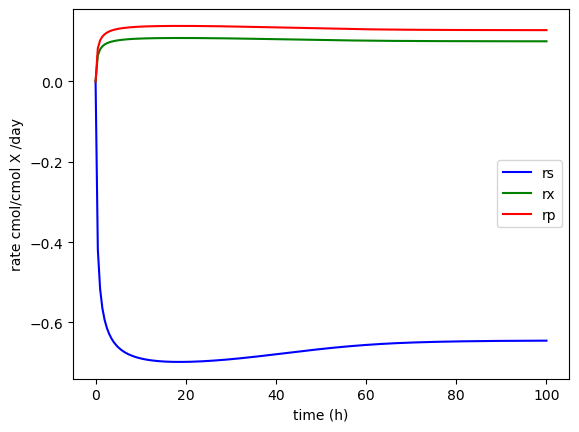

In [15]:
rs=r[:,0]
rx=r[:,1]
rp=r[:,2]

plt.figure(5)
plt.plot(tspan, rs, color='blue', label='rs')
plt.plot(tspan, rx, color='green', label='rx')
plt.plot(tspan, rp, color='red', label='rp')
plt.legend(loc='best')
plt.ylabel('rate cmol/cmol X /day') 
plt.xlabel('time (h)') 
plt.show()

Note that these rates are cell based with units of $\frac{cmol_i}{cmolX \cdot day}$. We can aslo plat the volumetric rates ($\frac{cmol_i}{L \cdot day}$) by doing this:

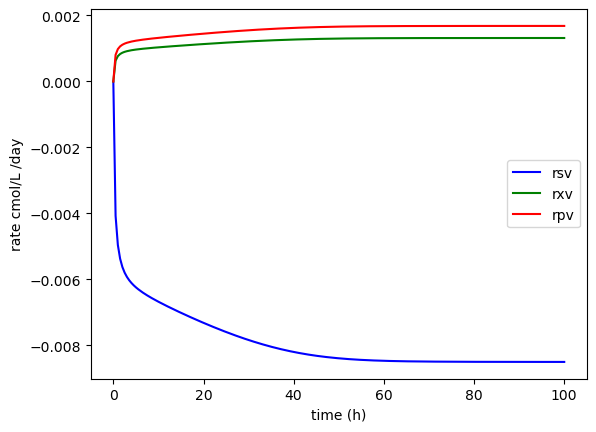

In [16]:
rsv=r[:,0]*Cx
rxv=r[:,1]*Cx
rpv=r[:,2]*Cx

plt.figure(5)
plt.plot(tspan, rsv, color='blue', label='rsv')
plt.plot(tspan, rxv, color='green', label='rxv')
plt.plot(tspan, rpv, color='red', label='rpv')
plt.legend(loc='best')
plt.ylabel('rate cmol/L /day') 
plt.xlabel('time (h)') 
plt.show()

Let's see if it is possible to achieve steady state quicker by having 0.15 cmol/L of substrate in the reactor at time zero. You should get something like this:

<img src="graph1.png" width="550" />

Ensure that your **ferm_eq_ss** function still solves for the same steady state. Fsolve does not always solve or converge, if this is the case try changing the initial guess.

Let's increase the throughput through the reactor to a **HRT** of 16 days. Let's also change the initial conditions in the reactor to $C_S$=0.05 $\frac{cmol}{L}$ and $C_X$=0.02 $\frac{cmol}{L}$; You should get this result:

<img src="graph2.png" width="550" />

See how $C_S$ in the outlet at steady state is much lower than before. Does this make sense? How does the conversion of substrate change when considering the above two examples?[86.8% vs 97.6%]

Also see what the cell based rate plot look like against time for the last example:

<img src="graph3.png" width="550" />

Why is the rate of substrate consumption $r_S$ declining with time?

Why is the rate of cell formation $r_X$ declining initially and then why does it stabalise?

Are you sure you can use **fsolve** for all these different starting conditions to find the final staeday state?

### Ensure that you are comfortable with the tools provided in this chapter, we will be using them extensively in the next chapters:

<img src="understand.png" width="550" />
